# Tutorial 08

## template fitting mock data test (EB mode, parametric CMB)

`Gaussian likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.ps_estimator import pstimator
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
import warnings
warnings.filterwarnings('ignore')

TARGET = 'EB'
NSIDE = 128
NSAMP = 10
APOSCALE = 6.
PSBIN = 50
LMIN = 50
LMAX = 200
FREQS = [95.,150.]
FWHM = [(52.8/60.)*np.pi/180.,(19./60.)*np.pi/180.,(11./60.)*np.pi/180.,(4.94/60.)*np.pi/180.]
KWARGS = {'nlive':1000}

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP+1,3,map23f.shape[1]),dtype=np.float32)
for i in range(NSAMP+1):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

map23 = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
map353 = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

fullmap = dict()
fullmap[95] = map95
fullmap[150] = map150

fullnoise = dict()
fullnoise[95] = nmap95[1:]
fullnoise[150] = nmap150[1:]

fullfiducial = dict()
fullfiducial[95] = mapcmb[1:]
fullfiducial[150] = mapcmb[1:]

fullbeam = dict()
fullbeam[95] = FWHM[1]
fullbeam[150] = FWHM[2]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### 1st run with sync model

- mock data frequencies: 95, 150
- template frequency: 23
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: WMAP, Ali
- foreground model: templated powerlaw

iter: 4858 | +1000 | bound: 3 | nc: 1 | ncall: 40054 | eff(%): 14.625 | loglstar:   -inf < -0.001 <    inf | logz: -4.643 +/-  0.090 | dlogz:  0.001 >  1.009                                         

Removed no burn in
Removed no burn in
reduced chi-sq  0.0002561560671502703
reduced chi-sq  0.000199454103678911
CPU times: user 26min 39s, sys: 17.2 s, total: 26min 56s
Wall time: 5min 23s


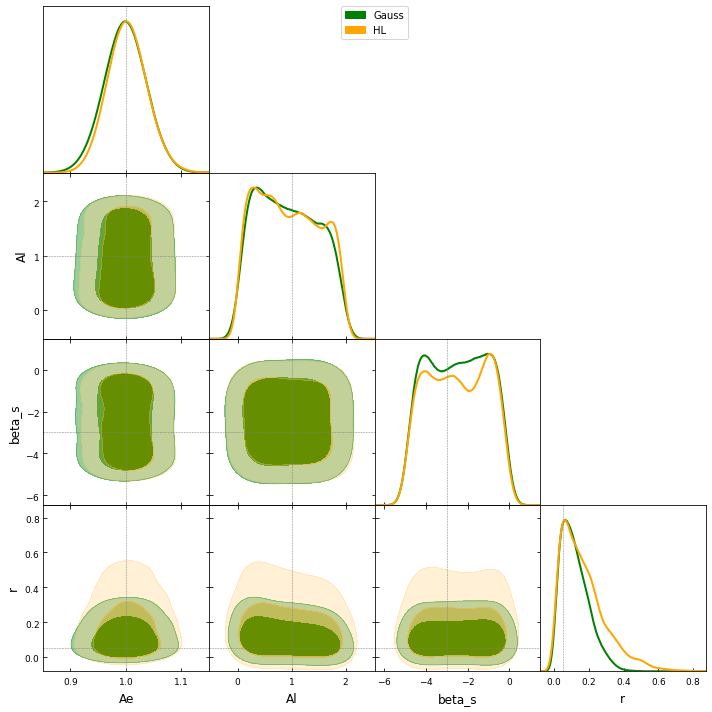

In [2]:
%%time

tmpmap = {23:map23}
tmpnoise = {23:nmap23}
tmpbeam = {23:FWHM[0]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground=syncmodel,background=cambmodel)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground
f.reset({'beta_s': -3.})
b = pipeline._background
b.reset({'Ae': 1.})
b.reset({'Al': 1.})
b.reset({'r': 0.05})
pipeline.background = b
pipeline.foreground = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.,1.,-3.,0.05,0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 2nd run with dust model

- mock data frequencies: 95, 150
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

iter: 6572 | +1000 | bound: 7 | nc: 1 | ncall: 45745 | eff(%): 16.553 | loglstar:   -inf < -0.010 <    inf | logz: -6.509 +/-  0.125 | dlogz:  0.001 >  1.009                                         

Removed no burn in
Removed no burn in
reduced chi-sq  0.008633220570440244
reduced chi-sq  0.0025810397996713203
CPU times: user 26min 34s, sys: 16.5 s, total: 26min 50s
Wall time: 5min 40s


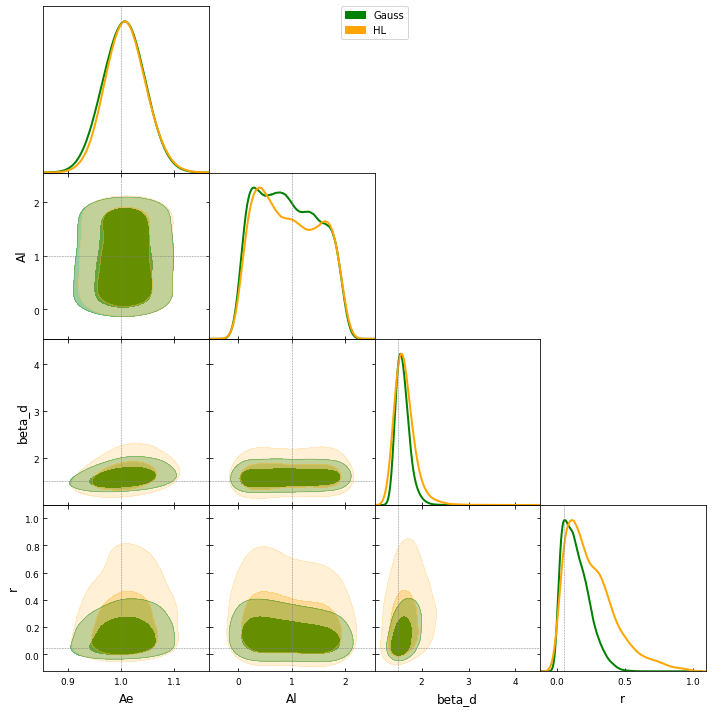

In [3]:
%%time

tmpmap = {353:map353}
tmpnoise = {353:nmap353}
tmpbeam = {353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground=dustmodel,background=cambmodel)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground
f.reset({'beta_d': 1.5})
b = pipeline._background
b.reset({'Ae': 1.})
b.reset({'Al': 1.})
b.reset({'r': 0.05})
pipeline.background = b
pipeline.foreground = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.,1.,1.5,0.05]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 3rd run with sync+dust model

- mock data frequencies: 95, 150
- template frequency: 23, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: WMAP, Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

iter: 6592 | +1000 | bound: 7 | nc: 1 | ncall: 46069 | eff(%): 16.480 | loglstar:   -inf < -0.028 <    inf | logz: -6.530 +/-  0.125 | dlogz:  0.001 >  1.009                                         

Removed no burn in
Removed no burn in
reduced chi-sq  0.0035446735508729266
reduced chi-sq  0.009275248473884818
CPU times: user 30min 54s, sys: 36 s, total: 31min 30s
Wall time: 6min 56s


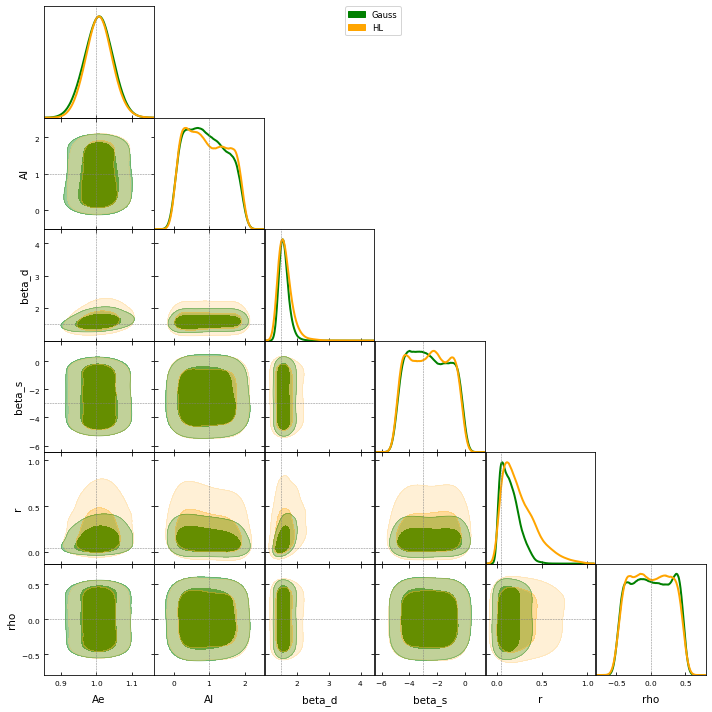

In [4]:
%%time

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground=syncdustmodel,background=cambmodel)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground
f.reset({'beta_s': -3.})
f.reset({'beta_d': 1.5})
f.reset({'rho': 0.})
b = pipeline._background
b.reset({'Ae': 1.})
b.reset({'Al': 1.})
b.reset({'r': 0.05})
pipeline.background = b
pipeline.foreground = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.,1.,1.5,-3.,0.05,0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

## template fitting mock data test (E mode, parametric CMB)

iter: 5061 | +1000 | bound: 4 | nc: 1 | ncall: 40315 | eff(%): 15.034 | loglstar:   -inf < -0.002 <    inf | logz: -4.885 +/-  0.104 | dlogz:  0.001 >  1.009                                         

Removed no burn in
Removed no burn in
reduced chi-sq  0.00020552486967633388
reduced chi-sq  0.0021064103457330953
CPU times: user 17min 16s, sys: 10.3 s, total: 17min 27s
Wall time: 3min 24s


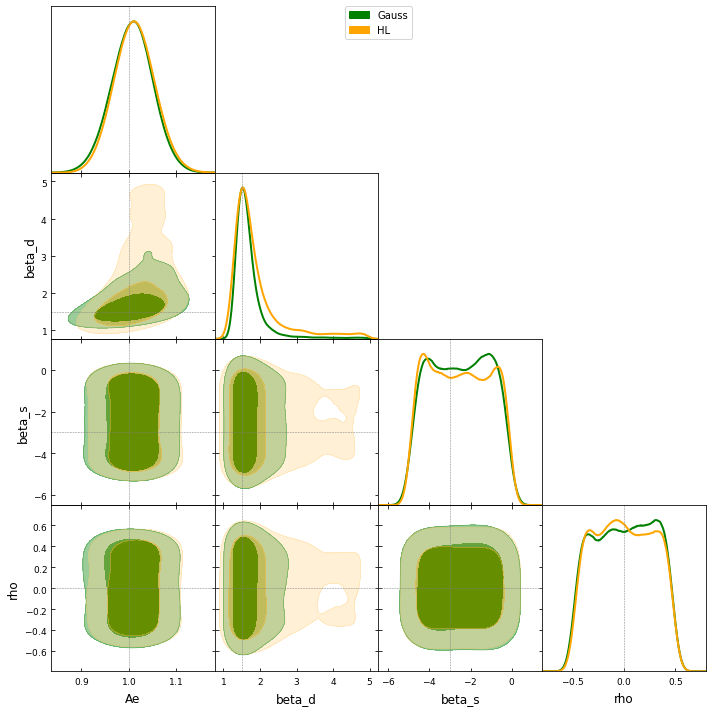

In [5]:
%%time

TARGET = 'E'

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground=syncdustmodel,background=cambmodel)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground
f.reset({'beta_s': -3.})
f.reset({'beta_d': 1.5})
f.reset({'rho': 0.})
b = pipeline._background
b.reset({'Ae': 1.})
b.reset({'Al': 1.})
b.reset({'r': 0.05})
pipeline.background = b
pipeline.foreground = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.,1.5,-3.,0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

## template fitting mock data test (B mode, parametric CMB)

iter: 6498 | +1000 | bound: 6 | nc: 1 | ncall: 43870 | eff(%): 17.091 | loglstar:   -inf < -0.008 <    inf | logz: -6.344 +/-  0.108 | dlogz:  0.001 >  1.009                                         

Removed no burn in
Removed no burn in
reduced chi-sq  0.0264670768957909
reduced chi-sq  0.015133037565179107
CPU times: user 19min 1s, sys: 19.3 s, total: 19min 21s
Wall time: 4min 6s


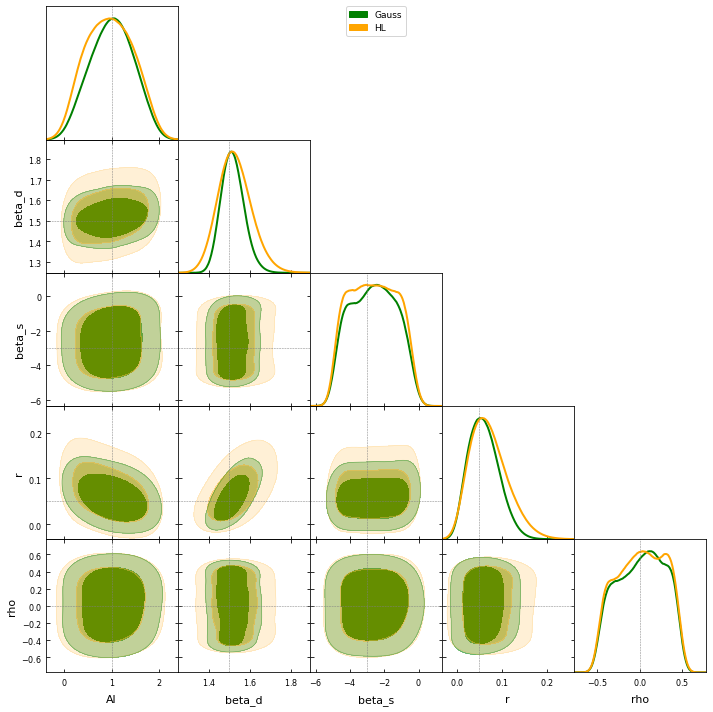

In [6]:
%%time

TARGET = 'B'

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground=syncdustmodel,background=cambmodel)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground
f.reset({'beta_s': -3.})
f.reset({'beta_d': 1.5})
f.reset({'rho': 0.})
b = pipeline._background
b.reset({'Ae': 1.})
b.reset({'Al': 1.})
b.reset({'r': 0.05})
pipeline.background = b
pipeline.foreground = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.,1.5,-3.,0.05,0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

end